In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import (ImageNormalize,
                                   PercentileInterval, MinMaxInterval, ZScaleInterval,
                                   SinhStretch, AsinhStretch, LinearStretch,
                                   make_rgb, make_lupton_rgb)


# RCS2_1032+6018 

In [15]:
#tbl = Table.read('catalogo_z.fits', hdu=2)
#apertures = fits.open('apertures_z.fits')
base_image_z = fits.open('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_z_11.fits')
base_image_g = fits.open('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_g_11.fits')
base_image_r = fits.open('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_r_11.fits')

31 viñetas dentro de 0.7 arcmin


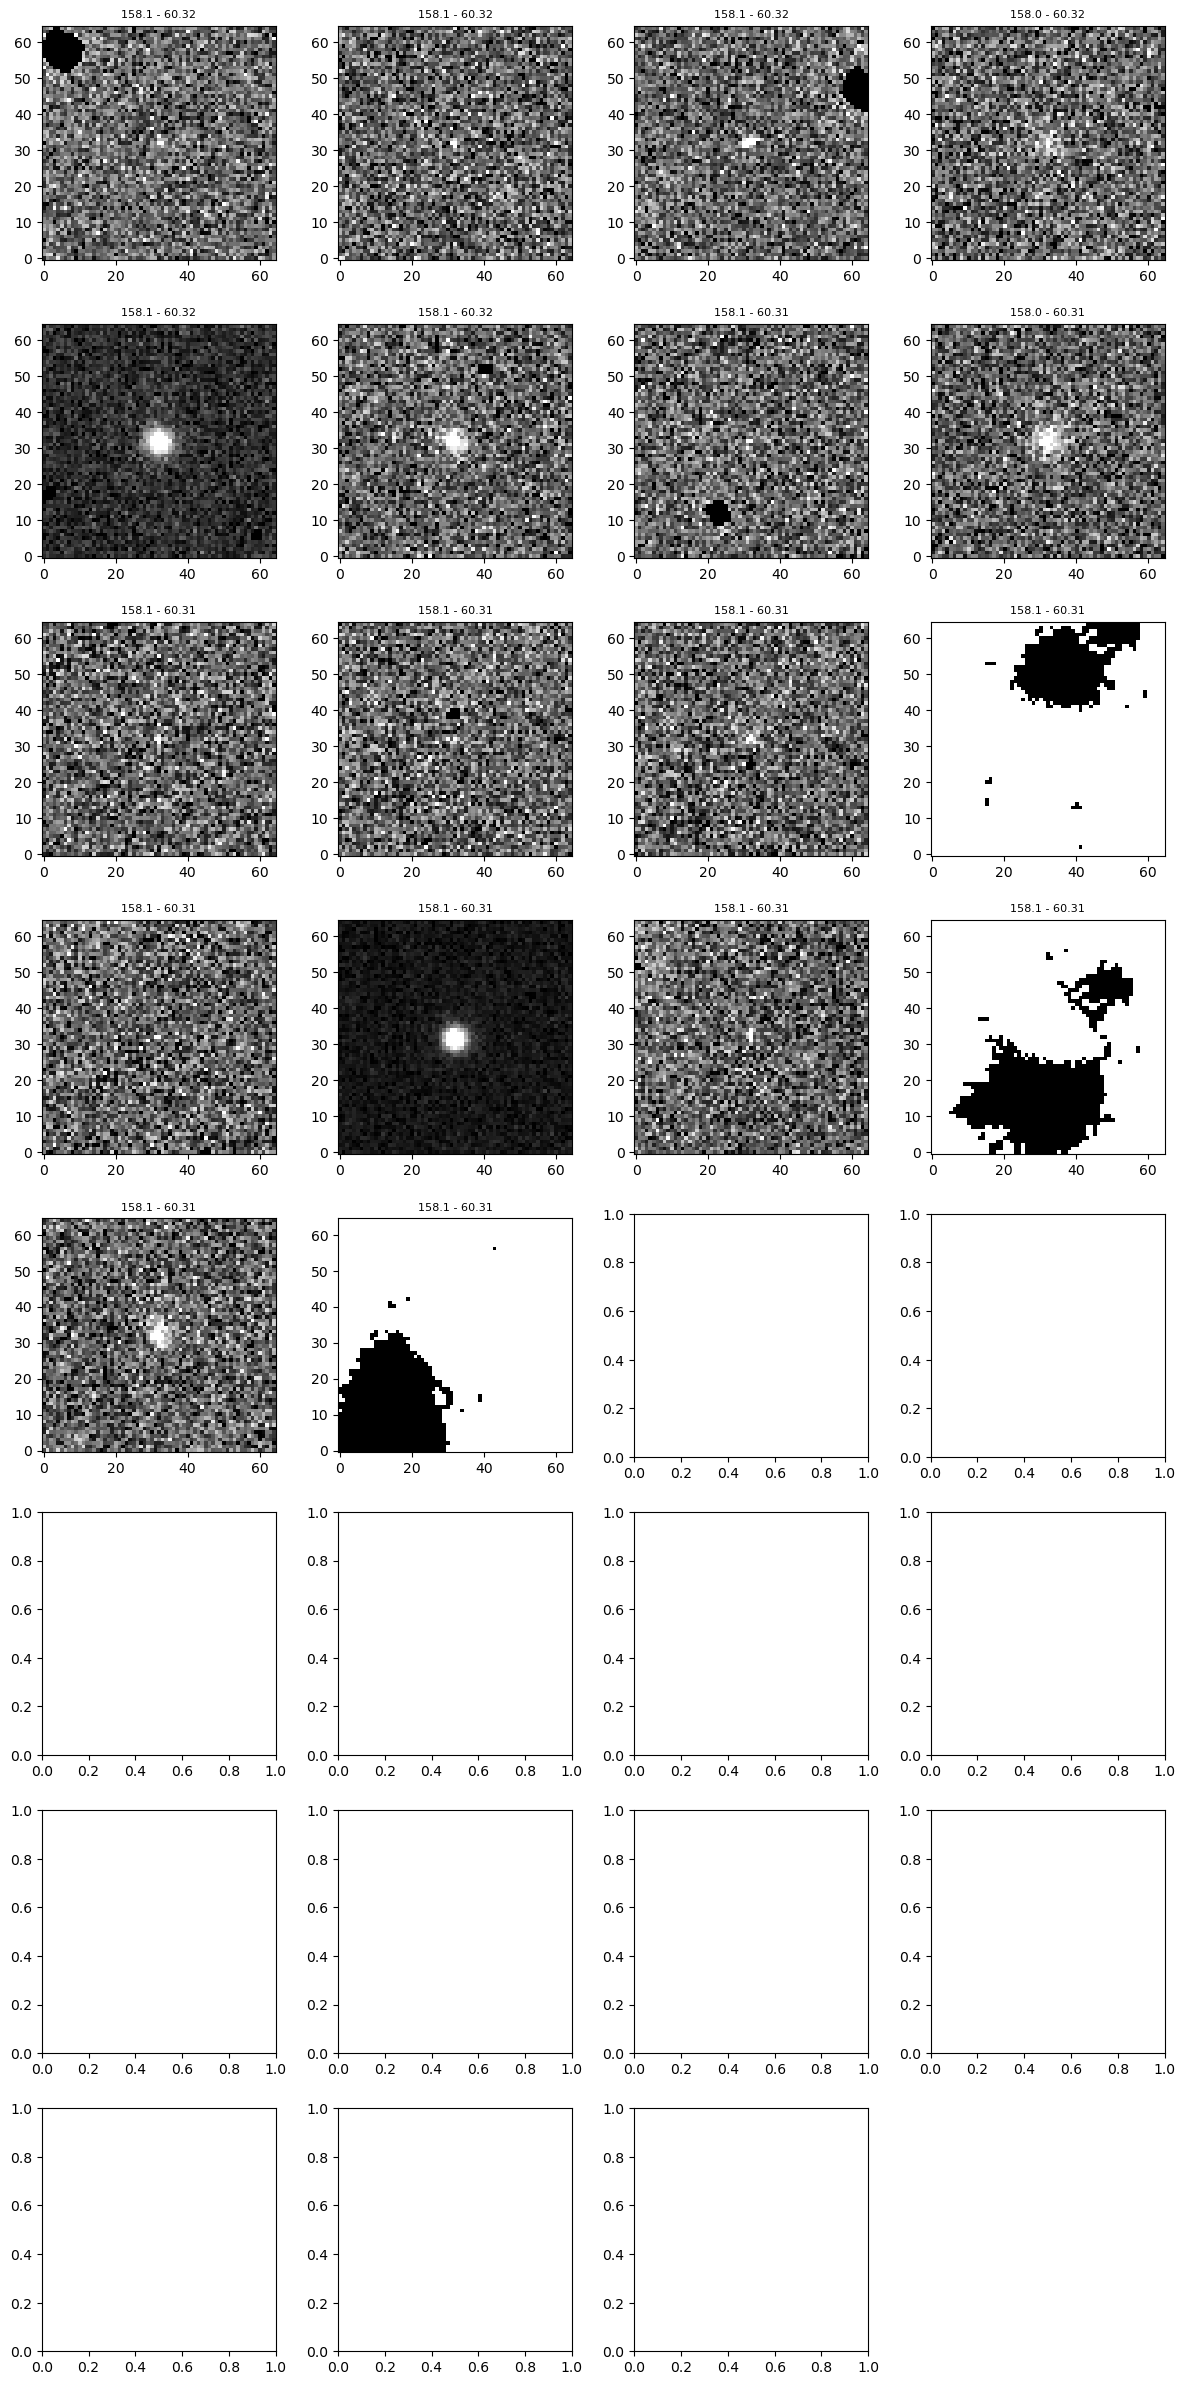

In [9]:
ra0, dec0 = "10:32:13", "60:18:26"
ra0 = SkyCoord(ra0, dec0, unit=(u.hourangle, u.deg)).ra.deg
dec0 = SkyCoord(ra0, dec0, unit=(u.hourangle, u.deg)).dec.deg
radius    = 0.7 * u.arcmin

# --- 2) Carga catálogo (extensión 2) ---
tbl    = Table.read('/data/estudiantes/riugarte/piripop/sex_RCS2/RCS2_1032+6018_PHOTOMETRY/catalogo_z.fits', hdu=2)
coords = SkyCoord(
    ra  = tbl['ALPHA_J2000'],
    dec = tbl['DELTA_J2000'],
    unit = (u.deg, u.deg)
)
center = SkyCoord(ra0*u.deg, dec0*u.deg)
mask   = center.separation(coords) < radius
sel    = tbl[mask]
n      = len(sel)
print(f"{n} viñetas dentro de {radius}")

# --- 3) Prepara la cuadrícula ---
cols = 4
rows = (n + cols - 1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()
i=0
# --- 4) Dibuja con normalización ---
for ax, row in zip(axes, sel):
    flat = row['VIGNET']
    side = int(np.sqrt(flat.size))
    stamp = flat.reshape(side, side)
    norm = ImageNormalize(stamp, interval=ZScaleInterval(), stretch=SinhStretch())
    im = ax.imshow(stamp, origin='lower', cmap='gray', vmin=np.percentile(stamp, 5), vmax=np.percentile(stamp, 99.5))
    ax.set_title(f"{row['ALPHA_J2000']:.4} - {row['DELTA_J2000']:.4}", fontsize=8)
    #ax.text({row['ALPHA_J2000']}, {row['DELTA_J2000']}, f"ID: {row['NUMBER']}", transform=ax.transAxes, fontsize=8,
    #        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    #ax.axis('off')
    i+=1
    if i==18:
        break

for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [6]:
wcs_z = WCS(fits.getheader('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_z_11.fits'))
wcs_g = WCS(fits.getheader('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_g_11.fits'))
wcs_r = WCS(fits.getheader('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_r_11.fits'))


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


31 fuentes dentro de 42.0 arcsec de 10h32m13s +60d18m26s


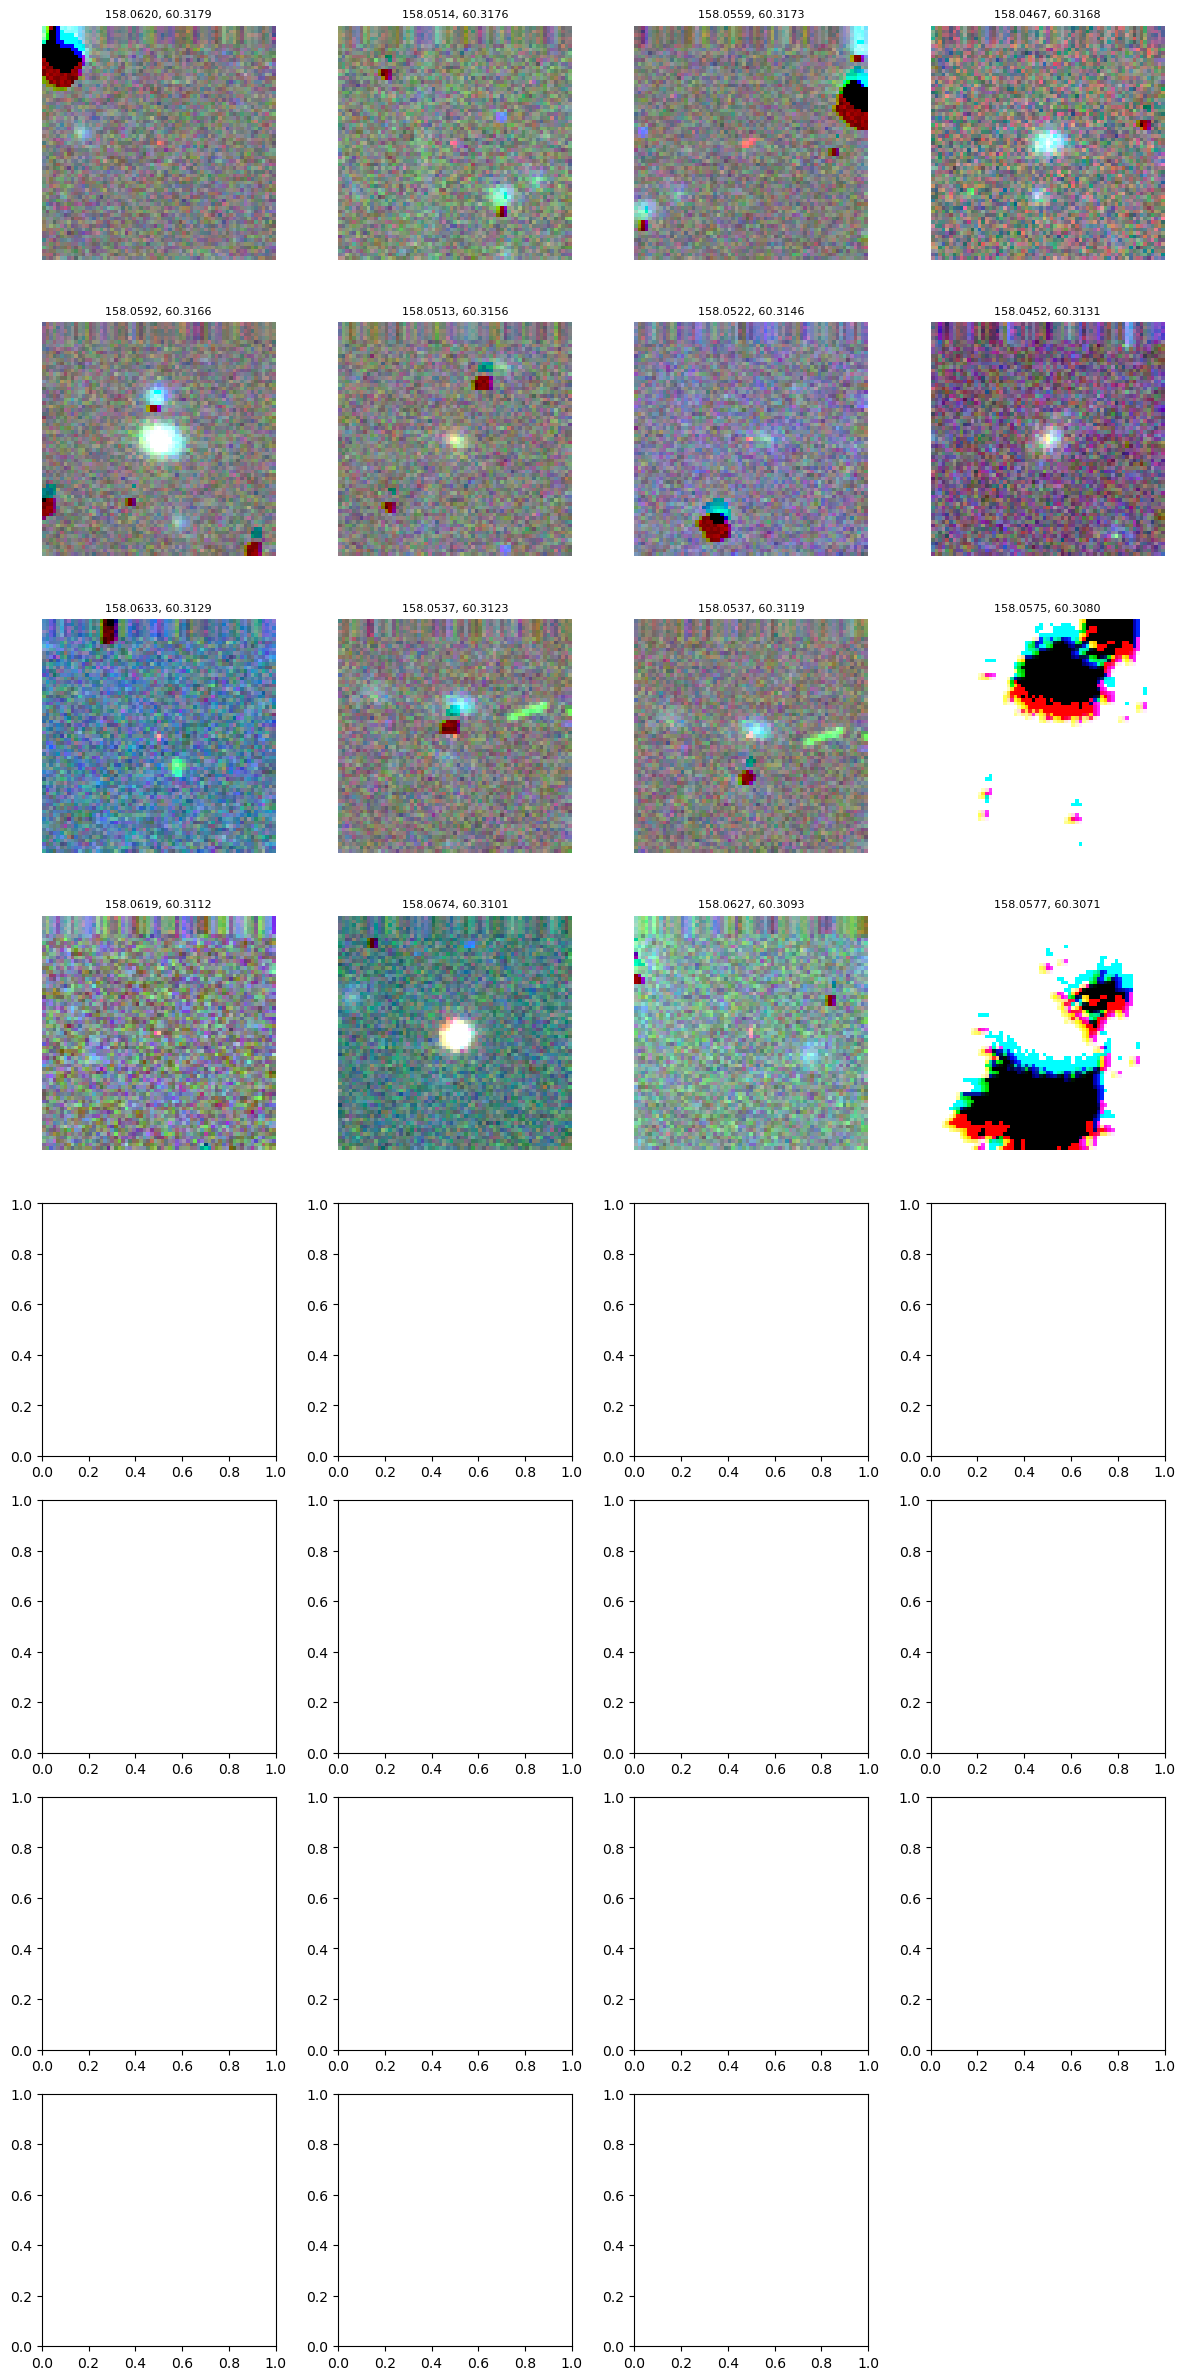

In [18]:
from scipy.ndimage import shift

classic = False
# --- 0) Parámetros centrales y radio en arcmin ---
ra0, dec0 = "10:32:13", "60:18:26"
coord0 = SkyCoord(ra0, dec0, unit=(u.hourangle, u.deg))
radius = 0.7 * u.arcmin

# --- 1) Carga los 3 catálogos LDAC (extensión 2) ---
tbl_z = Table.read("/data/estudiantes/riugarte/piripop/sex_RCS2/RCS2_1032+6018_PHOTOMETRY/catalogo_z.fits", hdu=2)
tbl_r = Table.read("/data/estudiantes/riugarte/piripop/sex_RCS2/RCS2_1032+6018_PHOTOMETRY/catalogo_r.fits", hdu=2)
tbl_g = Table.read("/data/estudiantes/riugarte/piripop/sex_RCS2/RCS2_1032+6018_PHOTOMETRY/catalogo_g.fits", hdu=2)

# --- 2) Construye SkyCoord para cada uno y filtra ---
coords = SkyCoord(tbl_z["ALPHA_J2000"],
                  tbl_z["DELTA_J2000"],
                  unit=(u.deg, u.deg))
mask   = coord0.separation(coords) < radius
sel_z  = tbl_z[mask]
sel_r  = tbl_r[mask]
sel_g  = tbl_g[mask]
n      = len(sel_z)
print(f"{n} fuentes dentro de {radius.to(u.arcsec)} de {coord0.to_string('hmsdms')}")

if n == 0:
    raise SystemExit("No hay detecciones en ese radio")

# --- 3) Prepara cuadrícula de 4 columnas ---
cols = 4
rows = (n + cols - 1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()
i=0
# --- 4) Para cada detección, monta el RGB ---
for ax, zrow, rrow, grow in zip(axes, sel_z, sel_r, sel_g):
    stamp_z = zrow["VIGNET"]
    stamp_r = rrow["VIGNET"]
    stamp_g = grow["VIGNET"]
    # Normalizaciones independientes (Asinh + ZScale)
    norm_z = ImageNormalize(stamp_z,
                            interval=ZScaleInterval(),
                            stretch=LinearStretch())
    norm_r = ImageNormalize(stamp_r,
                            interval=ZScaleInterval(),
                            stretch=LinearStretch())
    norm_g = ImageNormalize(stamp_g,
                            interval=ZScaleInterval(),
                            stretch=LinearStretch())

    coords_stamps_z = SkyCoord(ra = zrow['ALPHA_J2000'],
                        dec = zrow['DELTA_J2000'],
                        unit = (u.deg, u.deg))


    pix_z = wcs_z.world_to_pixel(coords_stamps_z)
    pix_g = wcs_g.world_to_pixel(coords_stamps_z)
    pix_r = wcs_r.world_to_pixel(coords_stamps_z)

    stamp_r_shifted = shift(stamp_r, (pix_z[1] - pix_r[1], pix_z[0] - pix_r[0]), mode='nearest', order=1)
    stamp_g_shifted = shift(stamp_g, (pix_z[1] - pix_g[1], pix_z[0] - pix_g[0]), mode='nearest', order=1)


    if classic:
        # Construir canal RGB: R=i-band (aquí 'z'), G=r, B=g
        rgb = np.zeros((side, side, 3), dtype=float)
        rgb[..., 0] = norm_z(stamp_z)  # Red
        rgb[..., 1] = norm_r(stamp_r)  # Green
        rgb[..., 2] = norm_g(stamp_g)  # Blue
    else:
        rgb = make_rgb(stamp_z, stamp_r_shifted, stamp_g_shifted,
                                    stretch=LinearStretch(),
                                    interval=ZScaleInterval())

    ax.imshow(rgb, origin="lower")
    ax.set_title(f"{zrow['ALPHA_J2000']:.4f}, {zrow['DELTA_J2000']:.4f}", fontsize=8)
    ax.axis("off")
    i+=1
    if i == 16:
        break
    

# Oculta ejes sobrantes
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


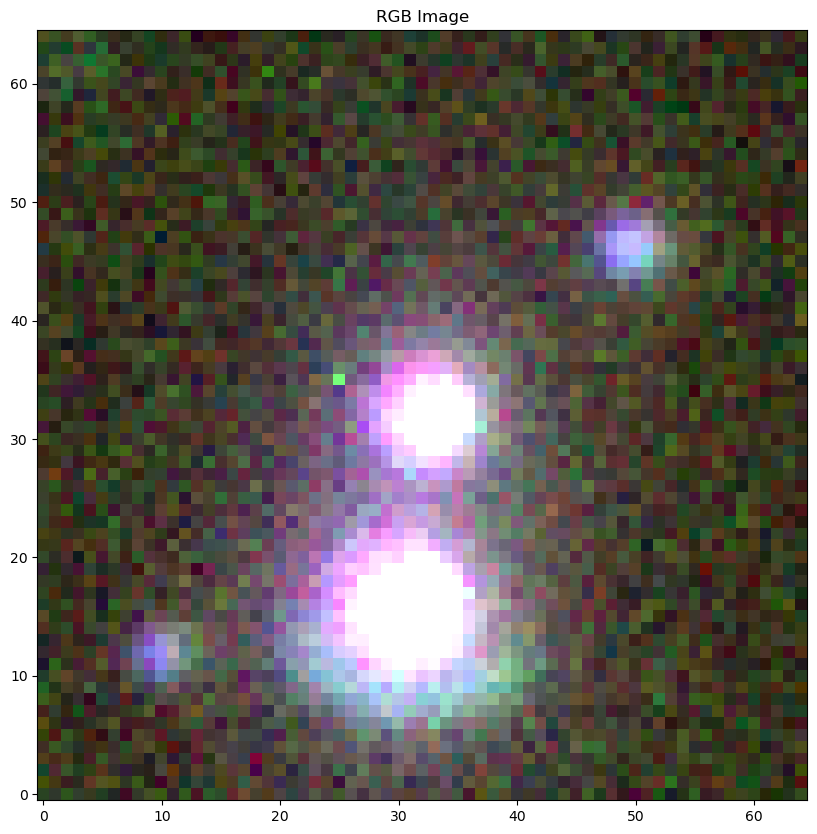

In [23]:
from astropy.nddata import Cutout2D


lente_stamp_z = Cutout2D(base_image_z[0].data, position=coords_stamps_z, wcs=wcs_z, size=[65,65])
lente_stamp_g = Cutout2D(base_image_g[0].data, position=coords_stamps_z, wcs=wcs_g, size=[65,65])
lente_stamp_r = Cutout2D(base_image_r[0].data, position=coords_stamps_z, wcs=wcs_r, size=[65,65])

# Make rgb image
rgb_image = make_rgb(
    lente_stamp_z.data, 
    lente_stamp_g.data, 
    lente_stamp_r.data,
    stretch=LinearStretch(),
    interval=ZScaleInterval()
)
# Display the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.title('RGB Image')
#plt.xlim(1100, 1300)
#plt.ylim(1100, 1300)
plt.show()


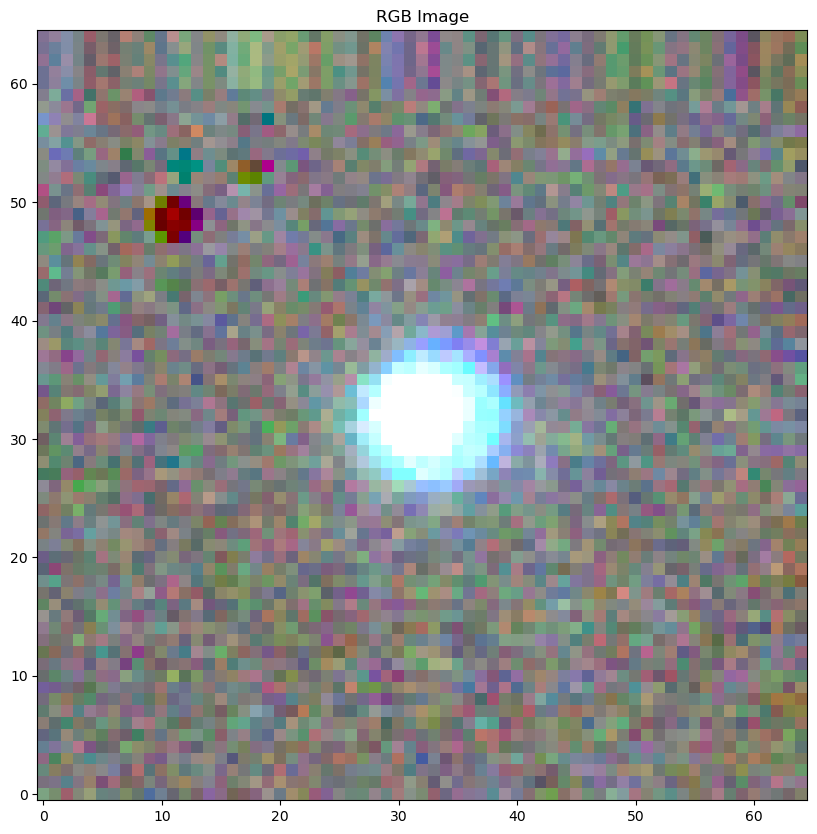

In [63]:
from scipy.ndimage import shift

stamp_r_shifted = shift(stamp_r, (pix_z[1] - pix_r[1], pix_z[0] - pix_r[0]), mode='nearest', order=1)
stamp_g_shifted = shift(stamp_g, (pix_z[1] - pix_g[1], pix_z[0] - pix_g[0]), mode='nearest', order=1)

# Make rgb image
rgb_image = make_rgb(
    stamp_z, 
    stamp_r_shifted, 
    stamp_g_shifted,
    stretch=LinearStretch(),
    interval=ZScaleInterval()
)
# Display the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.title('RGB Image')
#plt.xlim(1100, 1300)
#plt.ylim(1100, 1300)
plt.show()


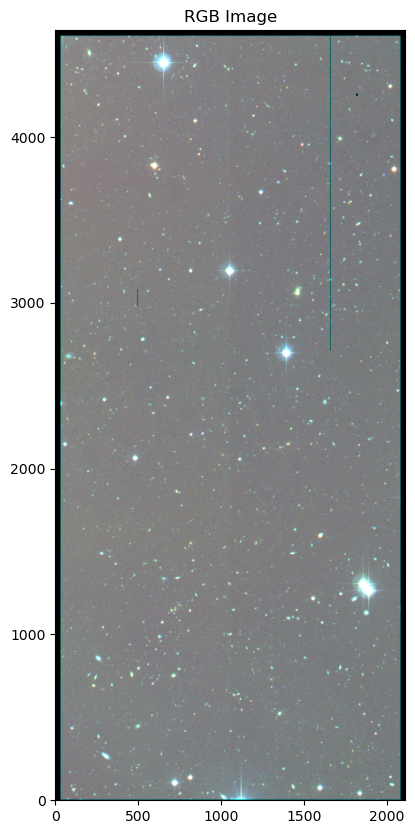

In [22]:
# importar make_rgb
z_image = fits.open('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_z_11.fits')
g_image = fits.open('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_g_11.fits')
r_image = fits.open('/data/estudiantes/riugarte/piripop/try2/RCS2_1032+6018/1040E5_r_11.fits')

# Make rgb image
rgb_image = make_rgb(
    z_image[0].data, 
    r_image[0].data, 
    g_image[0].data,
    stretch=LinearStretch(),
    interval=ZScaleInterval()
)
# Display the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.title('RGB Image')
#plt.xlim(1100, 1300)
#plt.ylim(1100, 1300)
plt.show()